## Классические алгоритмы без ансамблирования
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.75$ - 0 баллов
- $0.75 < AUC \leq 0.76$ - 2 балла
- $0.76 < AUC \leq 0.77$ - 4 балла
- $0.77 < AUC \leq 0.78$ - 6 баллов
- $0.78 < AUC \leq 0.79$ - 8 баллов
- $AUC > 0.79$ - 10 баллов

\
В этой работе запрещено использовать ансамбли моделей (лес, бустинги и т.д.)!

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [203]:
data = pd.read_csv('german.csv', sep=';')
data.drop_duplicates(inplace=True, ignore_index=True)
print(data.head())

X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()
X_pd = pd.DataFrame(X)  
y_pd = pd.DataFrame(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

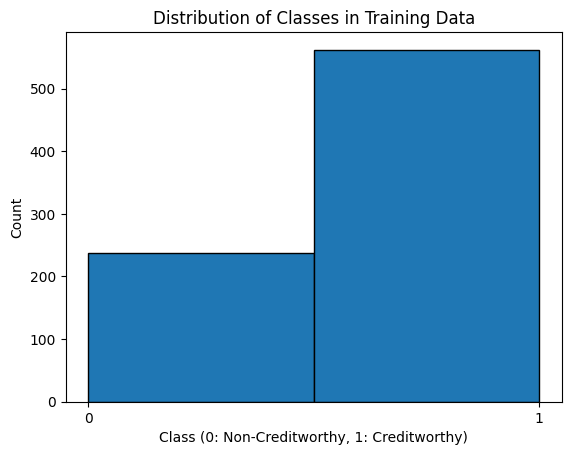

In [204]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

In [205]:
# Колонки соответсвуют смысловому содержанию, пропусков значений нет, категориальных признаков тоже нет
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account_Balance                    1000 non-null   int64
 2   Duration_of_Credit_monthly         1000 non-null   int64
 3   Payment_Status_of_Previous_Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit_Amount                      1000 non-null   int64
 6   Value_Savings_Stocks               1000 non-null   int64
 7   Length_of_current_employment       1000 non-null   int64
 8   Instalment_per_cent                1000 non-null   int64
 9   Sex_Marital_Status                 1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration_in_Current_address        1000 non-null   int64
 12  Most_valuable_availab

In [206]:
data.nunique()

Creditability                          2
Account_Balance                        4
Duration_of_Credit_monthly            33
Payment_Status_of_Previous_Credit      5
Purpose                               10
Credit_Amount                        923
Value_Savings_Stocks                   5
Length_of_current_employment           5
Instalment_per_cent                    4
Sex_Marital_Status                     4
Guarantors                             3
Duration_in_Current_address            4
Most_valuable_available_asset          4
Age_years                             53
Concurrent_Credits                     3
Type_of_apartment                      3
No_of_Credits_at_this_Bank             4
Occupation                             4
No_of_dependents                       2
Telephone                              2
Foreign_Worker                         2
dtype: int64

In [207]:
data.describe()

,Creditability,Account_Balance,Duration_of_Credit_monthly,Payment_Status_of_Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,Length_of_current_employment,Instalment_per_cent,Sex_Marital_Status,...,Duration_in_Current_address,Most_valuable_available_asset,Age_years,Concurrent_Credits,Type_of_apartment,No_of_Credits_at_this_Bank,Occupation,No_of_dependents,Telephone,Foreign_Worker
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,...,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.700000,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,...,2.845000,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.155000,1.404000,1.037000
std,0.458487,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,...,1.103718,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856
min,0.000000,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,...,2.000000,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,...,3.000000,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,1.000000,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,...,4.000000,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
max,1.000000,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,...,4.000000,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


Сразу видим что есть аномальные значения, слишком большой размах например в Duration_of_Credit_monthly и др. -> необходимо стандартиировать данные. Выводы из ячейки ниже мы применим для принятия решения о необходимости препроцессоринга данных, так же судя по всему колонка телефон не собо важна.

In [208]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred__lr_proba = pipeline_lr.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred__lr_proba)
print(f"ROC AUC модели с стандартизацией: {roc_auc}")

model_lr_without_scaler = LogisticRegression()
model_lr_without_scaler.fit(X_train, y_train)
y_pred_lr_proba_without_scaler = model_lr_without_scaler.predict_proba(X_test)[:, 1]
roc_auc_lr_without_scaler = roc_auc_score(y_test, y_pred_lr_proba_without_scaler)
print(f"ROC AUC модели без стандартизации: {roc_auc_lr_without_scaler}")

ROC AUC модели с стандартизацией: 0.7919588592800374
ROC AUC модели без стандартизации: 0.7788686302010286


c:\Users\lisichkin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [209]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn.fit(X_train, y_train)
y_pred_knn_proba = pipeline_knn.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_knn_proba)
print(f"ROC AUC модели с стандартизацией: {roc_auc}")

model_knn_without_scaler = KNeighborsClassifier()
model_knn_without_scaler.fit(X_train, y_train)
y_pred_knn_proba_without_scaler = model_knn_without_scaler.predict_proba(X_test)[:, 1]
roc_auc_knn_without_scaler = roc_auc_score(y_test, y_pred_knn_proba_without_scaler)
print(f"ROC AUC модели без стандартизации: {roc_auc_knn_without_scaler}")

ROC AUC модели с стандартизацией: 0.7483052828424497
ROC AUC модели без стандартизации: 0.5781907433380085


In [210]:
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier())
])

pipeline_dt.fit(X_train, y_train)
y_pred_dt_proba = pipeline_dt.predict_proba(X_test)[:, 1]
roc_auc_dt = roc_auc_score(y_test, y_pred_dt_proba)
print(f"ROC AUC модели с стандартизацией: {roc_auc}")

model_dt_without_scaler = DecisionTreeClassifier()
model_dt_without_scaler.fit(X_train, y_train)
y_pred_dt_proba_without_scaler = model_dt_without_scaler.predict_proba(X_test)[:, 1]
roc_auc__dt_without_scaler = roc_auc_score(y_test, y_pred_dt_proba_without_scaler)
print(f"ROC AUC модели без стандартизации: {roc_auc__dt_without_scaler}")

ROC AUC модели с стандартизацией: 0.7483052828424497
ROC AUC модели без стандартизации: 0.6832632071061243


In [211]:
# Выставим сразу solver - liblinear так как данных у нас не особо много
pipeline_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear'))
])
pipeline_logreg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [212]:
space_dt = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(3, 20)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(3, 25)),
    'min_samples_split': hp.choice('min_samples_split', range(3, 60))
}

def objective(params):
    pipline_dt = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(**params))
    ])
    pipline_dt.fit(X_train, y_train)
    y_pred_proba = pipline_dt.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)    
    return {'loss': -roc_auc, 'status': STATUS_OK}

trials = Trials()
best = fmin(objective, space_dt, algo=tpe.suggest, max_evals=1000, trials=trials)
print("Наилучшие гиперпараметры:", best)

100%|██████████| 1000/1000 [00:11<00:00, 87.18trial/s, best loss: -0.7967508181393175]
Наилучшие гиперпараметры: {'criterion': np.int64(0), 'max_depth': np.int64(5), 'min_samples_leaf': np.int64(15), 'min_samples_split': np.int64(45)}


In [213]:
param_grid = {
    'classifier__max_depth': range(5, 9),
    'classifier__min_samples_leaf': range(15, 21),
    'classifier__min_samples_split': range(45, 51)
}

pipline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(criterion='gini'))
])
grid_search = GridSearchCV(pipline_dt, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)
best_roc_auc = grid_search.best_score_
print("Лучший ROC-AUC на валидационной выборке:", best_roc_auc)
pipline_dt_best = grid_search.best_estimator_
y_pred_proba = pipline_dt_best.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC на тестовой выборке:", roc_auc_test)

Лучшие параметры: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 46}
Лучший ROC-AUC на валидационной выборке: 0.7053340165794711
ROC-AUC на тестовой выборке: 0.7315334268349696


In [214]:
# далее подбор осущ. вручную
pipline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(criterion='gini',
                                          max_depth=8,
                                          min_samples_leaf=20,
                                          min_samples_split=50))
])

pipline_dt.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=20,
                                        min_samples_split=50))])

In [217]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=800,
                                        weights="distance",
                                        algorithm="brute",
                                        leaf_size=1,
                                        metric="canberra"))
])
pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(algorithm='brute', leaf_size=1,
                                      metric='canberra', n_neighbors=800,
                                      weights='distance'))])

In [218]:
y_prob_logistic = pipeline_logreg.predict_proba(X_test)[:, 1]
y_prob_decision_tree = pipline_dt.predict_proba(X_test)[:, 1]
y_prob_knn = pipeline_knn.predict_proba(X_test)[:, 1]

y_pred_logistic = pipeline_logreg.predict(X_test)
y_pred_decision_tree = pipline_dt.predict(X_test)
y_pred_knn = pipeline_knn.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
roc_auc_decision_tree = roc_auc_score(y_test, y_prob_decision_tree)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

precision_logistic = precision_score(y_test, y_pred_logistic)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree)
precision_knn = precision_score(y_test, y_pred_knn)

recall_logistic = recall_score(y_test, y_pred_logistic)
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
recall_knn = recall_score(y_test, y_pred_knn)

print(f'Accuracy of Logistic Regression: {accuracy_logistic}')
print(f'Accuracy of Decision Tree: {accuracy_decision_tree}')
print(f'Accuracy of K-Nearest Neighbors: {accuracy_knn}')
print()
print(f'ROC AUC of Logistic Regression: {roc_auc_logistic}')
print(f'ROC AUC of Decision Tree: {roc_auc_decision_tree}')
print(f'ROC AUC of K-Nearest Neighbors: {roc_auc_knn}')
print()
print(f'Precision of Logistic Regression: {precision_logistic}')
print(f'Precision of Decision Tree: {precision_decision_tree}')
print(f'Precision of K-Nearest Neighbors: {precision_knn}')
print()
print(f'Recall of Logistic Regression: {recall_logistic}')
print(f'Recall of Decision Tree: {recall_decision_tree}')
print(f'Recall of K-Nearest Neighbors: {recall_knn}')

Accuracy of Logistic Regression: 0.755
Accuracy of Decision Tree: 0.785
Accuracy of K-Nearest Neighbors: 0.69

ROC AUC of Logistic Regression: 0.7919588592800374
ROC AUC of Decision Tree: 0.7949976624590929
ROC AUC of K-Nearest Neighbors: 0.7820243104254324

Precision of Logistic Regression: 0.7834394904458599
Precision of Decision Tree: 0.7950310559006211
Precision of K-Nearest Neighbors: 0.69

Recall of Logistic Regression: 0.8913043478260869
Recall of Decision Tree: 0.927536231884058
Recall of K-Nearest Neighbors: 1.0


## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели